# Nonlinear hyperdiffusion
Based on the hypothesis that the resolution is insufficient to accurately represent the fourth derivatives in the linear hyperdiffusion term, I propose a nonlinear hypediffusion that only requires second derivatives:
$$
    \nu' f(z) |\nabla^2 \vec{u}| \, \nabla^2 \vec{u},
$$
where $\nu$ is a hyperdiffusivity coefficient and $f(z)$ is a function that goes to $0$ at the top and bottom of the domain.
This is like the usual diffusion, with a variable coefficient.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import modules.math as math
from IPython.display import Video

## Choice of parameters
I choose $\nu' = 10^{-3}$ so the typical maximum values of the hyperdiffusion and normal diffusion terms are of the same order of magnitude. I also choose
$$
    f(z) = 1 - g(2z - 1),
$$
where
$$
    g(z) = 56z^{10} - 140z^{12} + 120z^{14} - 35z^{16}
$$
is a function chosen so that the first three derivatives of $f$ vanish at $z=0$ and $z=1$. This will mask out regions near the boundaries where the gradients in the variables are large. $f(z)$ and its Chebyshev coefficients are plotted below.

[Text(0.5, 0, 'Chebyshev mode'), Text(0, 0.5, '|coefficient|')]

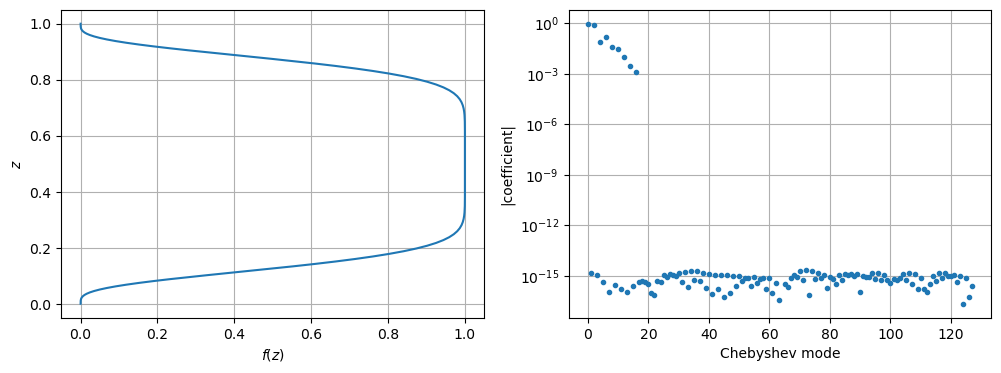

In [3]:
def taper_func(x):
    return 56*x**10 - 140*x**12 + 120*x**14 - 35*x**16

calculator = math.Math(1024, 128)
taper = calculator.dist.Field(bases=calculator.zbasis)
taper['g'] = (1 - taper_func(2*calculator.z - 1))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(taper['g'].squeeze(), calculator.z.squeeze())
axes[0].grid()
axes[0].set(xlabel='$f(z)$', ylabel='$z$')
axes[1].semilogy(np.abs(taper['c'].squeeze()), '.')
axes[1].grid()
axes[1].set(xlabel='Chebyshev mode', ylabel='|coefficient|')

$f(z)$ is well-resolved with less than 20 modes, so we hope it will not cause issues at coarser resolutions.

## Estimating the hyperdiffusion and regular diffusion terms
Before running the model with nonlinear hyperdiffusion, I use existing data to roughly visualise the contribution of the new term.

In [6]:
i_time = 600
hyper = 1e-3
data = xr.open_dataset('../data/highRa_basemodel_test/highRa_basemodel_test_s1.nc')

u = data.u.isel(t=i_time)
w = data.w.isel(t=i_time)
theta = data.theta.isel(t=i_time)

def laplacian(data):
    result = (
        data.differentiate('x').differentiate('x')
        + data.differentiate('z').differentiate('z')
    )
    return result

mag_lap_velocity = np.sqrt(laplacian(u)**2 + laplacian(w)**2)
taper = 1 - taper_func(2*data.z - 1)
u_terms = {
    r'$\nabla^2 u$': laplacian(u),
    r'$\nu f(z)|\nabla^2 \vec{u}| \nabla^2 u$': hyper*taper*mag_lap_velocity*laplacian(u),
}
w_terms = {
    r'$\nabla^2 w$': laplacian(w),
    r'$\nu f(z)|\nabla^2 \vec{u}| \nabla^2 w$': hyper*taper*mag_lap_velocity*laplacian(w),
}
theta_terms = {
    r'$\nabla^2 \theta$': laplacian(theta),
    r'$\nu f(z)|\nabla^2 \theta| \nabla^2 \theta$': hyper*taper*np.abs(laplacian(theta))*laplacian(theta),
}

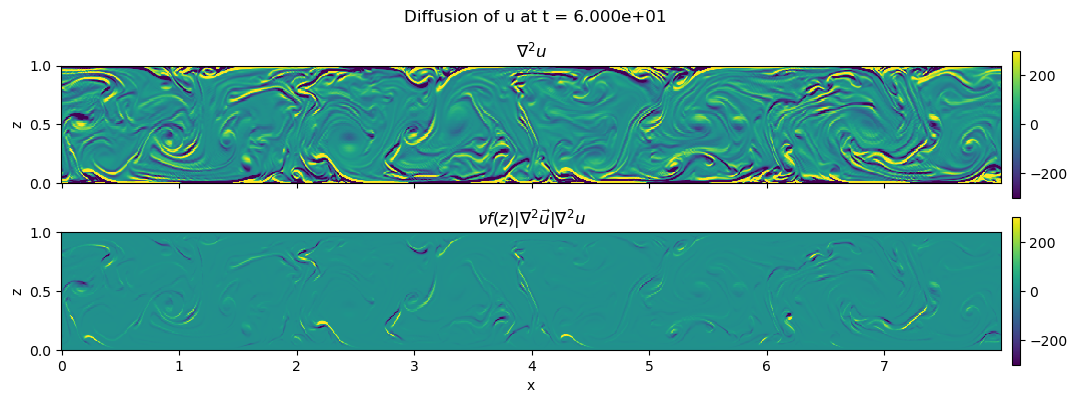

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(12, 4), sharex=True)

for i, term in enumerate(u_terms.keys()):
    array = u_terms[term].transpose('z', 'x')
    mesh = axes[i].pcolormesh(data.x, data.z, array)
    mesh.set_clim(-300, 300)
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i], pad=0.01)

axes[-1].set_xlabel('x')
fig.suptitle(f'Diffusion of u at t = {data.t[i_time]:.3e}', x=0.45)
fig.tight_layout()

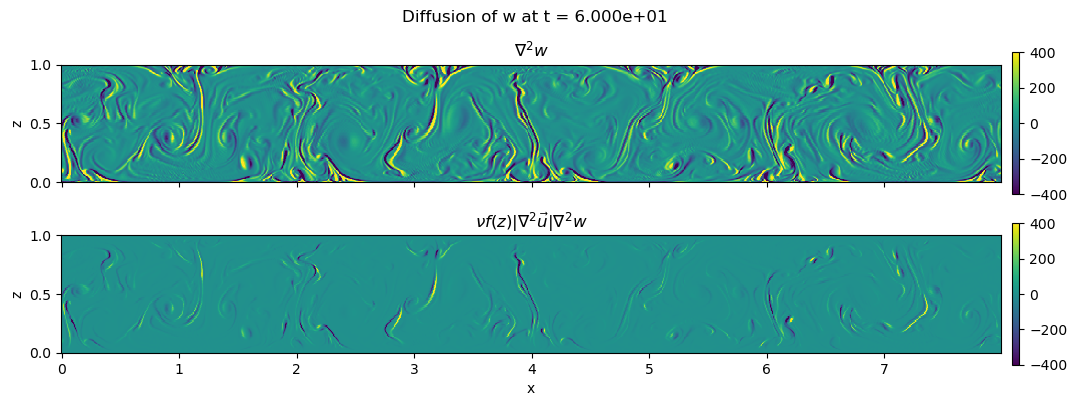

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(12, 4), sharex=True)

for i, term in enumerate(w_terms.keys()):
    array = w_terms[term].transpose('z', 'x')
    mesh = axes[i].pcolormesh(data.x, data.z, array)
    mesh.set_clim(-400, 400)
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i], pad=0.01)

axes[-1].set_xlabel('x')
fig.suptitle(f'Diffusion of w at t = {data.t[i_time]:.3e}', x=0.45)
fig.tight_layout()

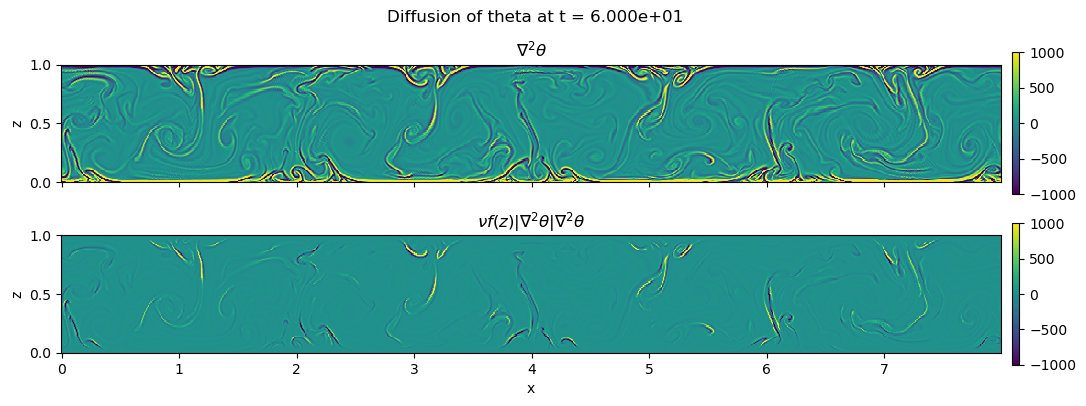

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(12, 4), sharex=True)

for i, term in enumerate(theta_terms.keys()):
    array = theta_terms[term].transpose('z', 'x')
    mesh = axes[i].pcolormesh(data.x, data.z, array)
    mesh.set_clim(-1e3, 1e3)
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i], pad=0.01)

axes[-1].set_xlabel('x')
fig.suptitle(f'Diffusion of theta at t = {data.t[i_time]:.3e}', x=0.45)
fig.tight_layout()

Observe that the nonlinear hyperdiffusion is biased towards regions where the normal diffusion is large, and goes to zero at the top and bottom boundaries.

## Running the model with nonlinear hyperdiffusion
Here is an animation of the model running with nonlinear hyperdiffusion:

In [3]:
Video('../data/restest_highRa_1024_128/restest_highRa_1024_128_s1.mp4')

And here is the model running without hyperdiffusion, and all other parameters the same: it crashes!

In [2]:
Video('../data/highRa_tests/highRa_basemodel_test/highRa_basemodel_test_s1.mp4')

## Effect of hyperdiffusion in Fourier space
To demonstrate that hyperdiffusion is having the intended effect, I plot the temperature fields in Fourier/Chebyshev coefficient space at $t=60$:

Text(0.45, 1.05, '$\\tilde{\\theta}(k_x, k_z)$ at t = 60.0')

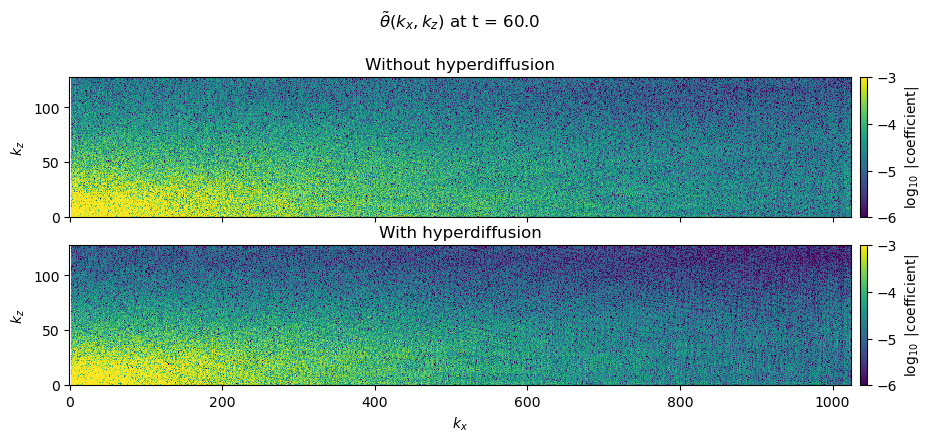

In [42]:
base_data = xr.open_dataset(
    '../data/highRa_basemodel_test/highRa_basemodel_test_s1.nc')
hyper_data = xr.open_dataset(
    '../data/nonlinear_hyperdiffusion_test/nonlinear_hyperdiffusion_test_s1.nc')

time = 60.
calc = math.Math(1024, 128)

fig, axes = plt.subplots(2, 1, figsize=(12, 4), sharex=True)
for i, data in enumerate([base_data, hyper_data]):
    coef = calc.space_coefficients(data.theta.sel(t=time, method='nearest'))
    mesh = axes[i].pcolormesh(coef.kx, coef.kz, np.log10(np.abs(coef.T)))
    mesh.set_clim(-6, -3)
    axes[i].set_ylabel('$k_z$')
    fig.colorbar(
        mesh, ax=axes[i], pad=0.01, label=r'$\log_{10}$ |coefficient|')

axes[0].set_title('Without hyperdiffusion')
axes[1].set(xlabel='$k_x$', title='With hyperdiffusion')
fig.suptitle(
    r'$\tilde{\theta}(k_x, k_z)$ at t = ' + f'{time:.1f}', x=0.45, y=1.05)

The coefficients of the highest modes are noticeably smaller in the model with hyperdiffusion, as expected.